##Importing the required modules

In [1]:
from google.colab import  drive
drive.mount('./gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/EVA S9/EVA/S11'

Mounted at ./gdrive
/content/gdrive/MyDrive/EVA S9/EVA/S11


In [2]:
import torch
import torchvision
from torch import optim
from torchsummary import summary
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In [3]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 952kB 32.1MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import albumentations as A
from utils import DataProcessing
from regularizations import Regularizations
from Model import CustomModel
from graphs import Graphs
from train import *
from test import *
from AlbumentationTransformations import  AlbumentationTransforms as AT
from albumentations import pytorch
from GradCam import *
from LR_Finder import *
from CyclicGraph import *
from Range_Test import *

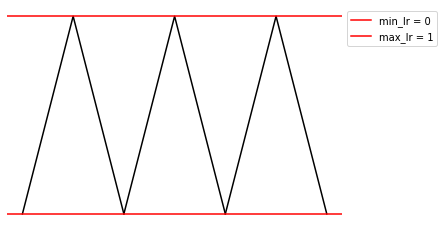

In [5]:
triangular_scheduler()

## Maintaining Reproducability

In [6]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

##Loading the Dataset, performing image transformations and loading the DataLoader

In [7]:
data = DataProcessing('CIFAR10')


In [8]:
train_set = data.Dataset('./Data', True, True, AT([A.PadIfNeeded(36, 36), A.RandomCrop(32,32), A.HorizontalFlip(), A.Cutout(), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), A.pytorch.ToTensor()]))
test_set = data.Dataset('./Data', False, True, AT([A.HorizontalFlip(), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), A.pytorch.ToTensor()]))


Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
train_set[0]

(tensor([[[-0.0667, -0.0431, -0.0667,  ..., -0.6000, -0.8588, -1.0000],
          [-0.0588, -0.1451, -0.0588,  ..., -0.3490, -0.6157, -0.8745],
          [-0.0510, -0.2627, -0.0510,  ..., -0.1686, -0.3176, -0.7020],
          ...,
          [-0.2392, -0.3490, -0.2392,  ...,  0.5216,  0.4588,  0.3569],
          [ 0.1843, -0.0353,  0.1843,  ...,  0.4745,  0.4039,  0.3176],
          [-0.2392, -0.3490, -0.2392,  ...,  0.5216,  0.4588,  0.3569]],
 
         [[-0.3490, -0.3176, -0.3490,  ..., -0.7882, -0.9373, -1.0000],
          [-0.3412, -0.4275, -0.3412,  ..., -0.6078, -0.7882, -0.9451],
          [-0.3333, -0.5137, -0.3333,  ..., -0.5059, -0.5765, -0.8431],
          ...,
          [-0.5137, -0.5843, -0.5137,  ...,  0.2000,  0.1294, -0.0353],
          [-0.0745, -0.2784, -0.0745,  ...,  0.1686,  0.1137,  0.0118],
          [-0.5137, -0.5843, -0.5137,  ...,  0.2000,  0.1294, -0.0353]],
 
         [[-0.6078, -0.5529, -0.6078,  ..., -0.9373, -1.0000, -1.0000],
          [-0.6078, -0.6706,

'truck'

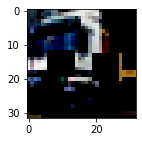

In [11]:
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(train_set[1][0],(1,2,0)))
train_set.classes[train_set[1][1]]


In [12]:
train_loader = data.DataLoader(train_set, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Taking a sneak peek at the dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


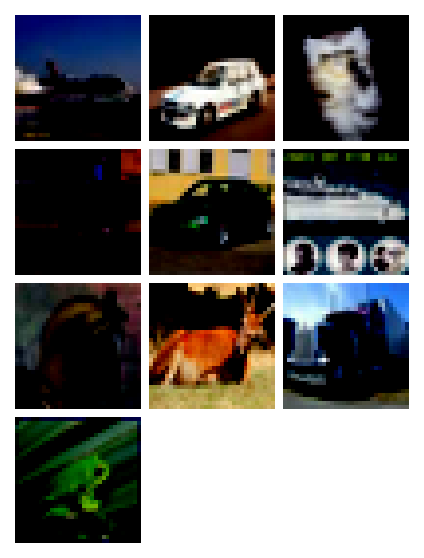

['ship', 'automobile', 'cat', 'horse', 'automobile', 'ship', 'horse', 'deer', 'truck', 'frog']


In [13]:
plt.figure(figsize=(10,10))
batch = next(iter(test_loader))
images, labels = batch
image, label = [],[]
for i in range(10):
  image.append(images[i])
  label.append(test_set.classes[labels[i]])

grid = torchvision.utils.make_grid(image, nrow=3, pad_value=1.0)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()
print(label)


## Viewing the parameter count used in the model

In [14]:
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = CustomModel().to(device) 
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Learning rate search finished. See the graph with {finder_name}.plot()


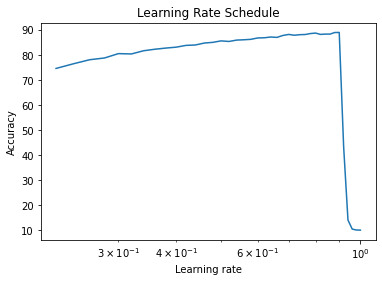

In [15]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5,momentum=0.9)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1,
                     epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [16]:
best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)] 
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))

Best Accuracy: 88.968
Best Learning Rate: 0.900184709124311


In [24]:
best_lr /= 10

##Loading the object for different regularizations

## Defining the main sequence of training and testing the model using the imported modules

In [17]:
regularizer = Regularizations('SGD', model, 0.01, 0.9, best_lr, len(train_loader))

In [18]:
def run(epochs, model, device, train_loader, regularizer, test_set, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  wrong_pred_data={'Images':[], 'Predicted':[], 'Actual':[]}  
  last_epoch = False
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, regularizer)
    if epoch == epochs - 1:
      last_epoch = True        
    test_loss, test_accuracy = test_model(model, device, test_set, test_loader, regularizer, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'], last_epoch)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
  return train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data

## Logging the results

In [19]:
train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data = run(24, model, device, train_loader, regularizer, test_set, test_loader)

Epoch 1 in progress....


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch : 1 

Average Train Loss : 0.015344398 
Train Accuracy :  11.4580% 

Average Test Loss : 0.301975464 
Test Accuracy :  9.0900% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.004781037 
Train Accuracy :  10.8080% 

Average Test Loss : 0.004575424 
Test Accuracy :  12.3700% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.004360264 
Train Accuracy :  14.8380% 

Average Test Loss : 0.004325113 
Test Accuracy :  18.4600% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.004109794 
Train Accuracy :  19.5320% 

Average Test Loss : 0.004083371 
Test Accuracy :  20.4700% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.004048452 
Train Accuracy :  19.6460% 

Average Test Loss : 0.004039086 
Test Accuracy :  18.7400% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.004016555 
Train Accuracy :  19.8480% 

Average Test Loss : 0.004358938 
Test Accuracy :  18.2800% 


Epoch 7 in progress....

Epoch : 7 

Average Train Lo

## Plotting the graph for the logged results

In [20]:
graphs = Graphs(1, 'Training Accuracy', 'Validation Accuracy')


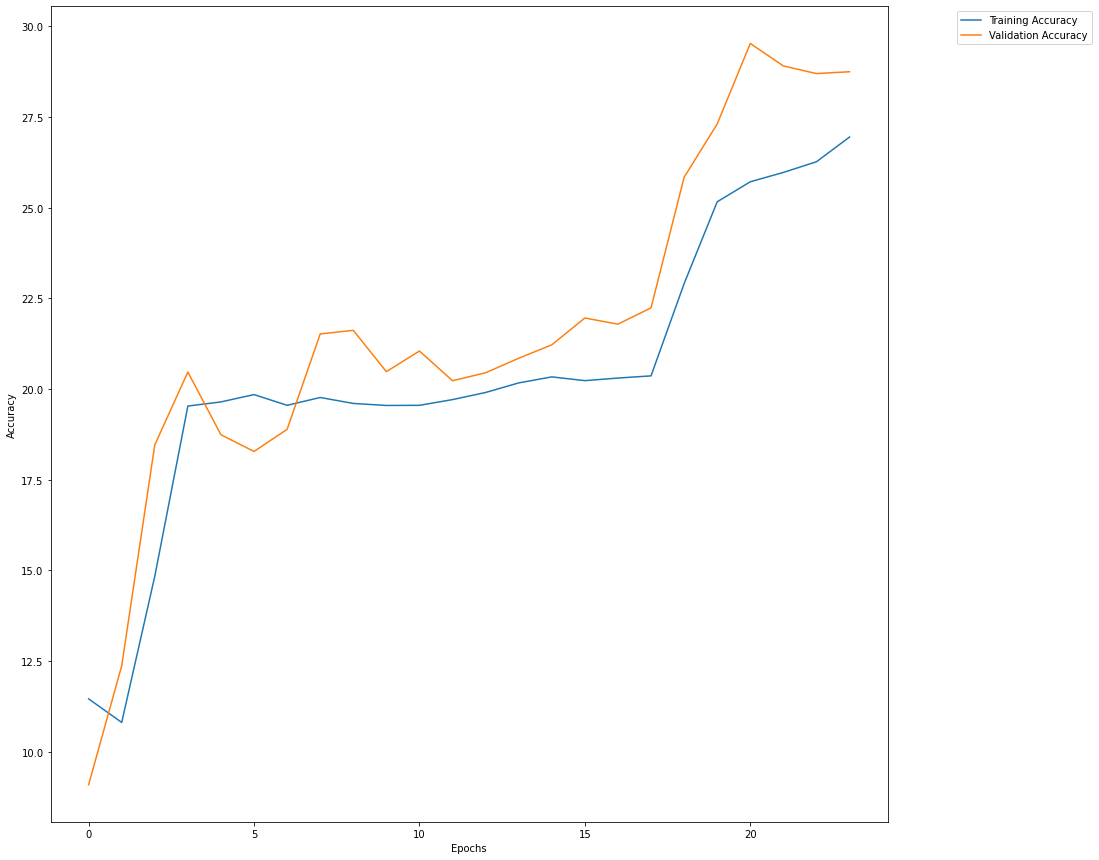

In [21]:
graphs.line_graph((15,15), train_accuracies, test_accuracies)


## Plotting 25 Misclassified Predictions

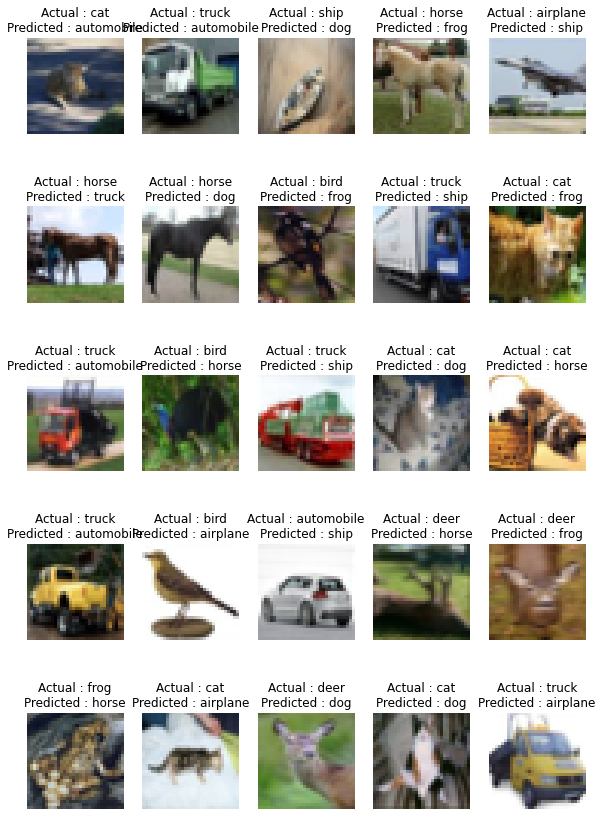

In [22]:
graphs.image_graph(5, 5, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'])

## GradCAM

In [23]:
layers = [model.layer_prep,model.layer_1b,model.layer_2,model.layer_3b]
GradCamView(wrong_pred_data,model,layers)